In [1]:
from dateutil.parser import parse
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams.update({'figure.figsize':(10,7),'figure.dpi':120})

df=pd.read_csv('../beans-with-dollar.csv')



In [2]:
df = df.reset_index()
df = df[['Date', 'Kandy']]
df = df.set_index('Date')
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reset_index()
df

,Date,Kandy
0,2020-01-01,310.000000
1,2020-01-02,274.166667
2,2020-01-03,238.333333
3,2020-01-04,202.500000
4,2020-01-05,166.666667
...,...,...
1454,2023-12-25,555.000000
1455,2023-12-26,565.000000
1456,2023-12-27,575.000000
1457,2023-12-28,525.000000


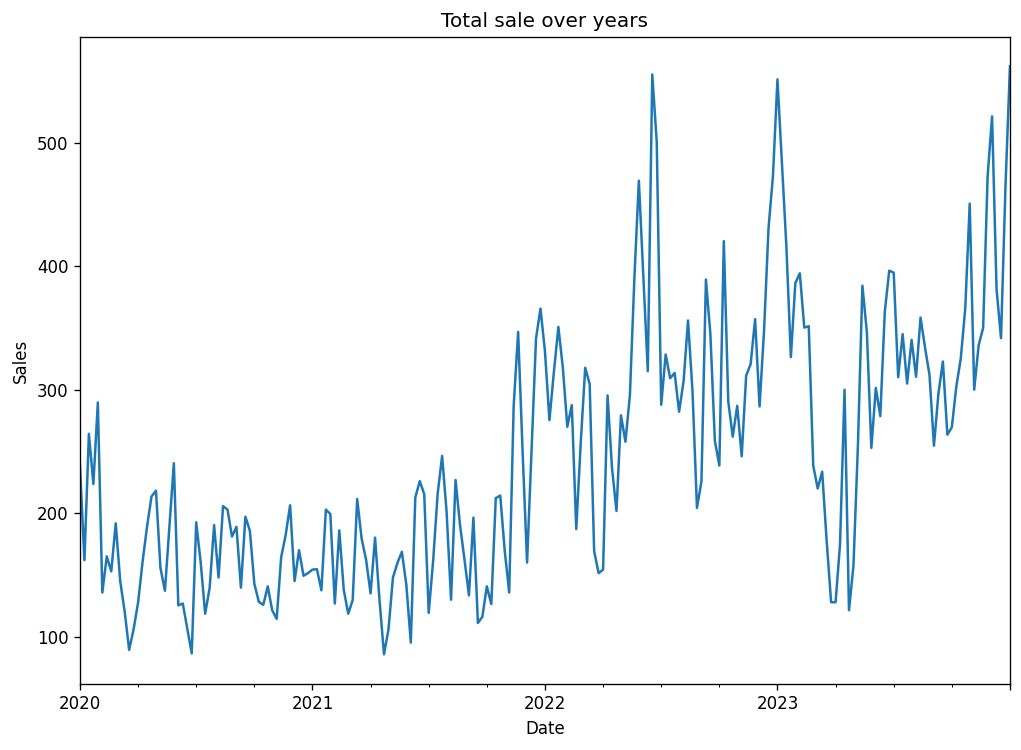

In [3]:

df['Date'] = pd.to_datetime(df['Date'])
df= df.set_index('Date')

df = df.resample('W').mean()
df = df.reset_index()
df.columns = ['Date', 'Kandy']
df.set_index('Date', inplace=True)

df['Kandy'].plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Total sale over years')
plt.show()

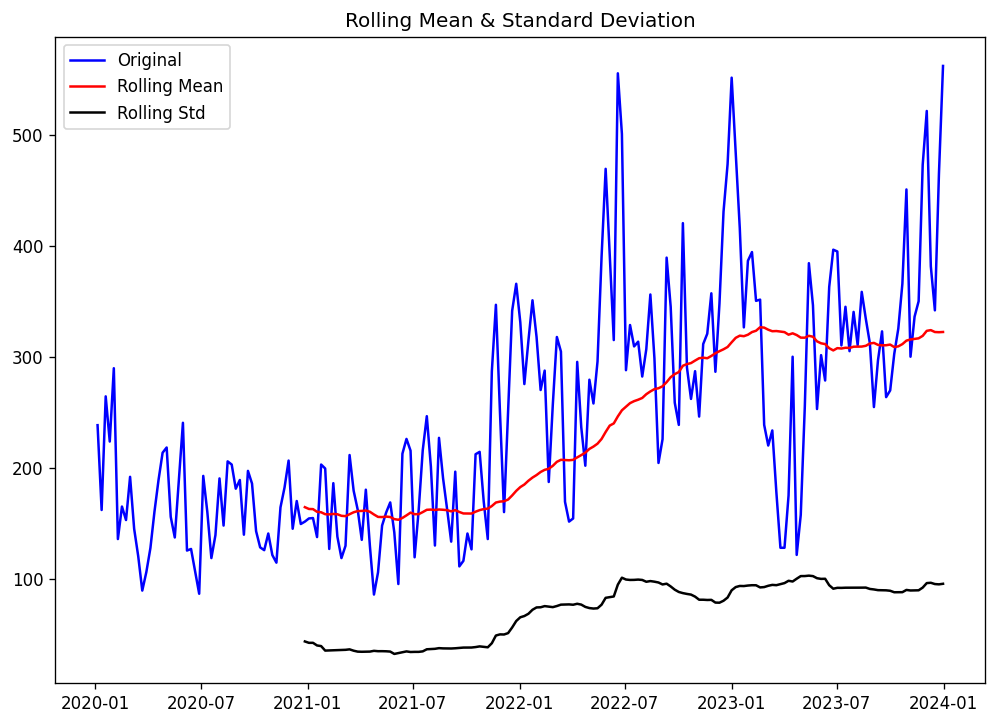

In [4]:

moving_avg = df.rolling(52).mean()
moving_std= df.rolling(52).std()
#Plot rolling statistics:
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
std = plt.plot(moving_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [5]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.717608
p-value                          0.842136
#Lags Used                      14.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


In [6]:

train_size = int(0.95 * len(df))

train = df[:train_size]
test = df[train_size:]

In [7]:
import pmdarima

from pmdarima import auto_arima
auto_arima(df,test='adf',       # use adftest to find optimal 'd'
                       # maximum p and q
                                 # frequency of series
                       # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       

                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2315.562, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2540.871, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2331.715, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2414.304, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2929.832, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2313.580, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2367.555, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2328.793, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2315.389, Time=0.27 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2365.461, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2321.304, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2304.423, Time=0.34 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2294.878, Time=0.44 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2293.349, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True)

In [8]:
import statsmodels.api as sm
model1=sm.tsa.statespace.SARIMAX(train,order=(3, 0, 2),seasonal_order=(3,0,2,52))

results=model1.fit(method='powell')
results.summary()

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Optimization terminated successfully.
         Current function value: 5.444357
         Iterations: 4
         Function evaluations: 453


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Kandy   No. Observations:                  198
Model:             SARIMAX(3, 0, 2)x(3, 0, 2, 52)   Log Likelihood               -1077.983
Date:                            Sun, 13 Oct 2024   AIC                           2177.965
Time:                                    14:30:41   BIC                           2214.136
Sample:                                01-05-2020   HQIC                          2192.606
                                     - 10-15-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4477      0.157      9.248      0.000       1.141       1.755
ar.L2         -1.0328      0.222     -4.659      0.000      -1.467      -0.598
ar.L3          0.5738      0.112      5.126      0.000       0.354       0.793
ma.L1         -0.8031      0.189     -4.246      0.000      -1.174      -0.432
ma.L2          0.4235      0.158      2.686      0.007       0.114       0.733
ar.S.L52       0.1517    840.917      0.000      1.000   -1648.016    1648.319
ar.S.L104     -0.0067   1357.173  -4.92e-06      1.000   -2660.017    2660.004
ar.S.L156      0.0699    178.907      0.000      1.000    -350.581     350.721
ma.S.L52      -0.0033    844.359  -3.92e-06      1.000   -1654.917    1654.911
ma.S.L104      0.0028   1238.170   2.27e-06      1.000   -2426.765    2426.771
sigma2      3046.5092    360.899      8.441      0.000    2339.159    3753.859
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.31
Prob(Q):                              0.91   Prob(JB):                         0.19
Heteroskedasticity (H):               2.15   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
pre=results.predict(start= len(train), end= (len(df)-1),dynamic=True)
pre

2023-10-22    300.164953
2023-10-29    285.324365
2023-11-05    280.889351
2023-11-12    301.722249
2023-11-19    303.963556
2023-11-26    303.829410
2023-12-03    283.301321
2023-12-10    292.770628
2023-12-17    303.692559
2023-12-24    308.289598
2023-12-31    316.502802
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [10]:
from  sklearn.metrics import mean_absolute_percentage_error

mape= mean_absolute_percentage_error(test, pre)

print('MAPE: %f' %mape)
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE directly using root_mean_squared_error
rmse = root_mean_squared_error(test, pre)

# Print the RMSE
print('RMSE: %f' % rmse)
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(test, pre)

# Print the MAE
print('MAE: %f' % mae)
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(test, pre))

# Print the RMSLE
print('RMSLE: %f' % rmsle)

MAPE: 0.252318
RMSE: 139.716688
MAE: 115.140837
RMSLE: 0.360133


In [11]:
test


,Kandy
Date,
2023-10-22,365.714286
2023-10-29,450.714286
2023-11-05,300.000000
2023-11-12,336.071429
2023-11-19,350.000000
2023-11-26,472.857143
2023-12-03,521.428571
2023-12-10,381.428571
2023-12-17,341.785714


In [12]:
pre

2023-10-22    300.164953
2023-10-29    285.324365
2023-11-05    280.889351
2023-11-12    301.722249
2023-11-19    303.963556
2023-11-26    303.829410
2023-12-03    283.301321
2023-12-10    292.770628
2023-12-17    303.692559
2023-12-24    308.289598
2023-12-31    316.502802
Freq: W-SUN, Name: predicted_mean, dtype: float64

<Axes: xlabel='Date'>

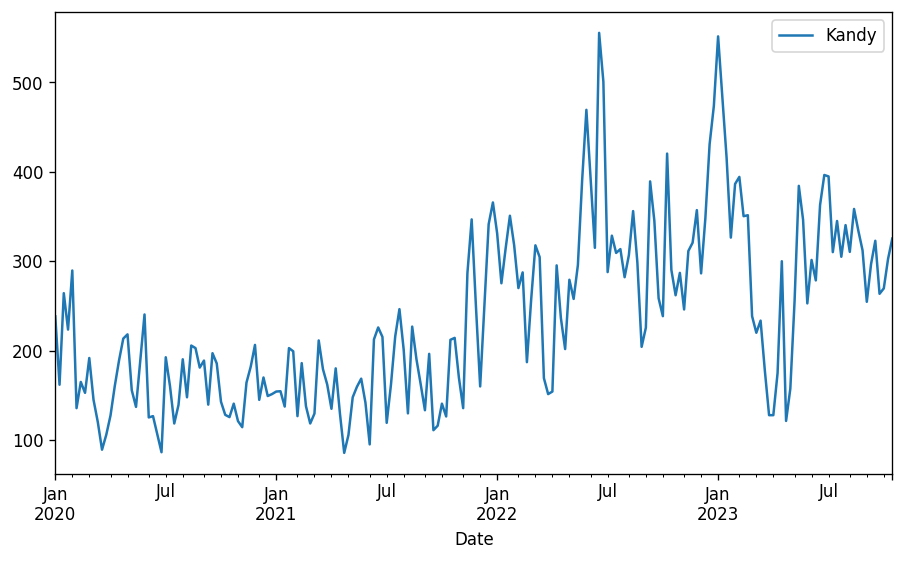

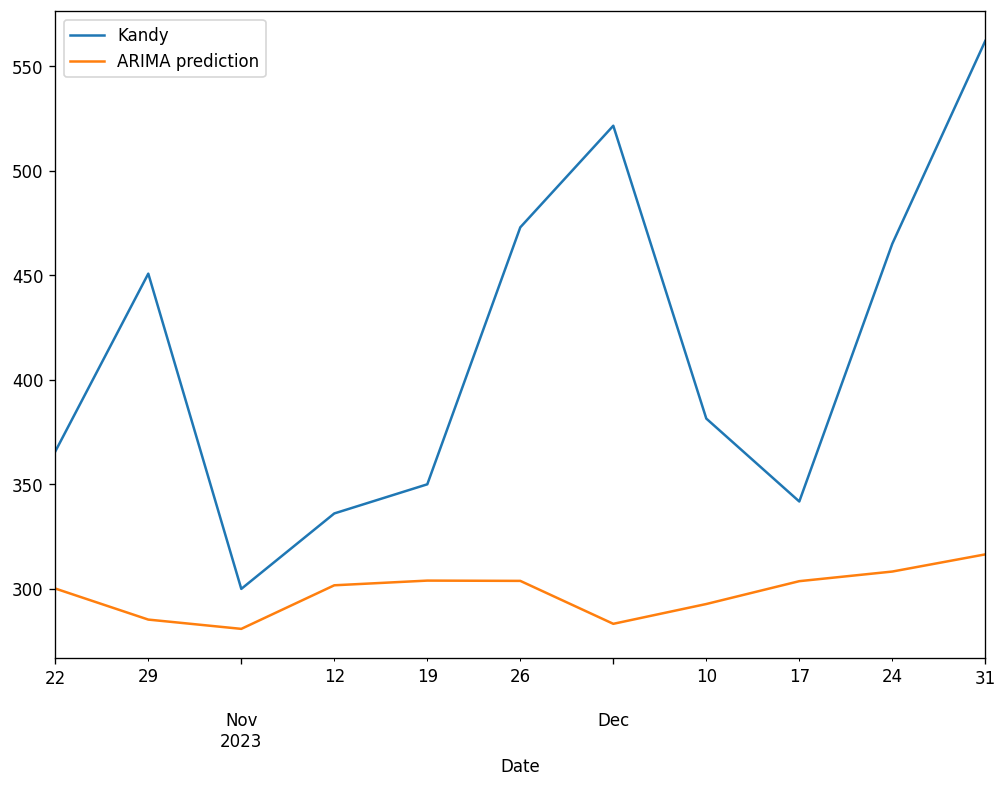

In [13]:
train.plot(legend=True, label='Train', figsize=(9,5))

test.plot(legend=True, label= 'Test')

pre.plot(legend=True, label='ARIMA prediction')